# Q18

An industry analyst is interested in building a predictive model to understand the impact of various factors and opening week revenue numbers in the overall collections of a movie (Total revenue). Box Office collection of Bollywood movies were recorded. The data is provided in file: MLR_Q18_MovieBoxOffice_data.csv.
Link: https://drive.google.com/drive/folders/1ILKastUTJWccxaxIpJpjqCJDpsMJ-oC8

Question:

    1) Identify the variables that can be used to fit a linear regression model. 
    2) How is the total revenue impacted by genre of the movie? 
    3) Does the release month have any role to play in movie's success? 
    4) Use any variable reduction technique to fit a model using all relevant variables. 
    5) Do you find any outliers in the dataset? What could be the possible reason for those being outliers? 

In [1]:
import numpy as np
import pandas as pd 

import seaborn as sns 
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv("MLR_Q18_MovieBoxOffice_data.csv")

#df.head(1)

In [3]:
# We must remove movie_name and Year, since these wont make sense in linear regression model
# We should also remove movie_director, since it has too many levels as compared to overall data

In [4]:
df[['revenue_total', 'revenue_opening_day', 'revenue_opening_weekend', 'revenue_firstweek', 
    "runtime"
   ]].corr()
# very high correlation of revenue_firstweek with revenue_opening_day(93%), revenue_opening_weekend(97%), 
# hence we will have to remove these variables, since analyst wants revenue_firstweek in model,
# interpreted based on the problem statement

,revenue_total,revenue_opening_day,revenue_opening_weekend,revenue_firstweek,runtime
revenue_total,1.000000,0.815177,0.883404,0.948234,0.437772
revenue_opening_day,0.815177,1.000000,0.972230,0.933651,0.514162
revenue_opening_weekend,0.883404,0.972230,1.000000,0.973736,0.501872
revenue_firstweek,0.948234,0.933651,0.973736,1.000000,0.493948
runtime,0.437772,0.514162,0.501872,0.493948,1.000000


In [5]:
cat_vars = ["movie_genre", "release_month"]
df_dummy = pd.get_dummies(df.drop(['movie_name', 'movie_director', 'release_year'], axis=1), prefix="gp", 
                           columns=cat_vars, 
                           drop_first=True)
#df_dummy.head()
#df_dummy.columns

In [6]:
# check the vif values, before forward feature selection
# 1
#    Remove runtime, since its vif is highest 28.007742
from statsmodels.stats.outliers_influence import variance_inflation_factor
x_var = ['revenue_firstweek', 'gp_Biographical', 'gp_Comedy',
         'gp_Crime', 'gp_Dance', 'gp_Drama', 'gp_Historical', 'gp_Horror',
         'gp_Musical', 'gp_Period', 'gp_Romance', 'gp_Sci-fi', 'gp_Social',
         'gp_Sports', 'gp_Spy', 'gp_Thriller', 'gp_Aug', 'gp_Dec', 'gp_Feb',
         'gp_Jan', 'gp_Jul', 'gp_Jun', 'gp_Mar', 'gp_May', 'gp_Nov', 'gp_Oct',
         'gp_Sep'
        ]
X = df_dummy[x_var]
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], index=X.columns)

revenue_firstweek    3.028858
gp_Biographical      1.760929
gp_Comedy            2.354879
gp_Crime             1.490167
gp_Dance             1.142188
gp_Drama             2.504715
gp_Historical        1.296740
gp_Horror            1.419047
gp_Musical           1.160864
gp_Period            1.088402
gp_Romance           1.474151
gp_Sci-fi            1.153154
gp_Social            1.152798
gp_Sports            1.152978
gp_Spy               1.004405
gp_Thriller          1.452523
gp_Aug               1.563805
gp_Dec               1.819822
gp_Feb               2.381611
gp_Jan               2.315917
gp_Jul               1.399362
gp_Jun               1.996338
gp_Mar               1.817453
gp_May               1.327469
gp_Nov               1.702940
gp_Oct               2.020214
gp_Sep               2.077541
dtype: float64

In [7]:
def fit_lin_reg_with_intercept(X, Y):
    X = sm.add_constant(X) # adding a constan
    reg_model = sm.OLS(Y,X).fit()
    return reg_model

In [8]:
# build 1st model, using all possible variables
var_list = ['revenue_firstweek', 'gp_Biographical', 'gp_Comedy',
         'gp_Crime', 'gp_Dance', 'gp_Drama', 'gp_Historical', 'gp_Horror',
         'gp_Musical', 'gp_Period', 'gp_Romance', 'gp_Sci-fi', 'gp_Social',
         'gp_Sports', 'gp_Spy', 'gp_Thriller', 'gp_Aug', 'gp_Dec', 'gp_Feb',
         'gp_Jan', 'gp_Jul', 'gp_Jun', 'gp_Mar', 'gp_May', 'gp_Nov', 'gp_Oct',
         'gp_Sep'
        ]
y = df_dummy['revenue_total']
reg_model  = fit_lin_reg_with_intercept(df_dummy[var_list], y)
p_values = reg_model.pvalues
size = p_values.size
p_values = p_values[1:size] # remove intercept 
p_values = pd.DataFrame({'variable_name' : p_values.index, 'p_value' : p_values.values})
#print(reg_model.summary())

In [9]:
x_var_list = var_list
# remove variables based on p-values and stop when only significant variables are present in data
p_values.sort_values('p_value', ascending=False, inplace=True, ignore_index=True)

y = df_dummy['revenue_total']
while p_values['p_value'][0] > 0.05:
    max_p_value = p_values['p_value'][0]
    var_to_remove = p_values['variable_name'][0]
    print(f"variable removed is : {var_to_remove}")
    x_var_list.remove(var_to_remove) 
    
    reg_model  = fit_lin_reg_with_intercept(df_dummy[x_var_list], y)
    p_values = reg_model.pvalues
    size = p_values.size
    p_values = p_values[1:size] # remove intercept 
    p_values = pd.DataFrame({'variable_name' : p_values.index, 'p_value' : p_values.values})
    p_values.sort_values('p_value', ascending=False, inplace=True, ignore_index=True)

variable removed is : gp_Romance
variable removed is : gp_Jun
variable removed is : gp_Oct
variable removed is : gp_Spy
variable removed is : gp_Mar
variable removed is : gp_Horror
variable removed is : gp_Biographical
variable removed is : gp_Musical
variable removed is : gp_Social
variable removed is : gp_Feb
variable removed is : gp_Sep
variable removed is : gp_Thriller
variable removed is : gp_Drama
variable removed is : gp_Jul
variable removed is : gp_May
variable removed is : gp_Sports
variable removed is : gp_Aug
variable removed is : gp_Dec
variable removed is : gp_Sci-fi
variable removed is : gp_Dance
variable removed is : gp_Period
variable removed is : gp_Nov
variable removed is : gp_Crime


In [10]:
x_var_list

['revenue_firstweek', 'gp_Comedy', 'gp_Historical', 'gp_Jan']

In [11]:
reg_model  = fit_lin_reg_with_intercept(df_dummy[x_var_list], y)
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:          revenue_total   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     325.6
Date:                Wed, 25 May 2022   Prob (F-statistic):           4.62e-65
Time:                        22:31:25   Log-Likelihood:                -593.11
No. Observations:                 130   AIC:                             1196.
Df Residuals:                     125   BIC:                             1211.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.4260      3.28

In [12]:
# Outliers - calculate cook's distance and dffits 
infl = reg_model.get_influence()
sm_fr = infl.summary_frame()
sm_fr.sort_values(by = ['cooks_d'], ascending=False, inplace=True, ignore_index=True)
sm_fr[sm_fr['cooks_d'] > 1]

,dfb_const,dfb_revenue_firstweek,dfb_gp_Comedy,dfb_gp_Historical,dfb_gp_Jan,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits


In [13]:
sm_fr.dffits.max()

1.919944787545428

In [14]:
(n, p) = df_dummy[x_var_list].shape
import math
d_cut_off = 2 * math.sqrt(p/n)
sm_fr[sm_fr['dffits'] > d_cut_off]

,dfb_const,dfb_revenue_firstweek,dfb_gp_Comedy,dfb_gp_Historical,dfb_gp_Jan,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.280145,0.262276,0.058879,1.410716,0.487492,0.556181,2.687742,0.277955,1.667605,2.757846,1.711100
1,-0.144219,0.377514,-0.137473,-0.552769,1.763363,0.554780,5.629261,0.080490,1.665503,6.489254,1.919945
5,-0.035499,0.592067,-0.220475,-0.118377,-0.102959,0.095130,3.574665,0.035888,0.689675,3.757575,0.724965
6,-0.175328,0.574916,-0.120808,-0.093546,-0.043390,0.074686,1.962799,0.088365,0.611091,1.985773,0.618244
8,-0.152938,0.490322,-0.100775,-0.079264,-0.035637,0.054517,1.641255,0.091894,0.522096,1.652580,0.525699


In [15]:
index_oulier = sm_fr[sm_fr['dffits'] > d_cut_off].index
df_dummy.iloc[index_oulier][x_var_list + ['revenue_total']]

,revenue_firstweek,gp_Comedy,gp_Historical,gp_Jan,revenue_total
0,9.36,0,0,0,9.36
1,90.67,0,0,0,93.37
5,32.60,0,0,0,34.99
6,39.65,0,0,0,58.04
8,20.21,1,0,1,27.91


In [16]:
df_plot = df_dummy[['revenue_firstweek', 'revenue_total']].copy()
df_plot['outlier'] = "Normal"
df_plot.loc[index_oulier, ['outlier']] = "Outlier"

In [17]:
#df_plot.head(5)

<AxesSubplot:xlabel='revenue_firstweek', ylabel='revenue_total'>

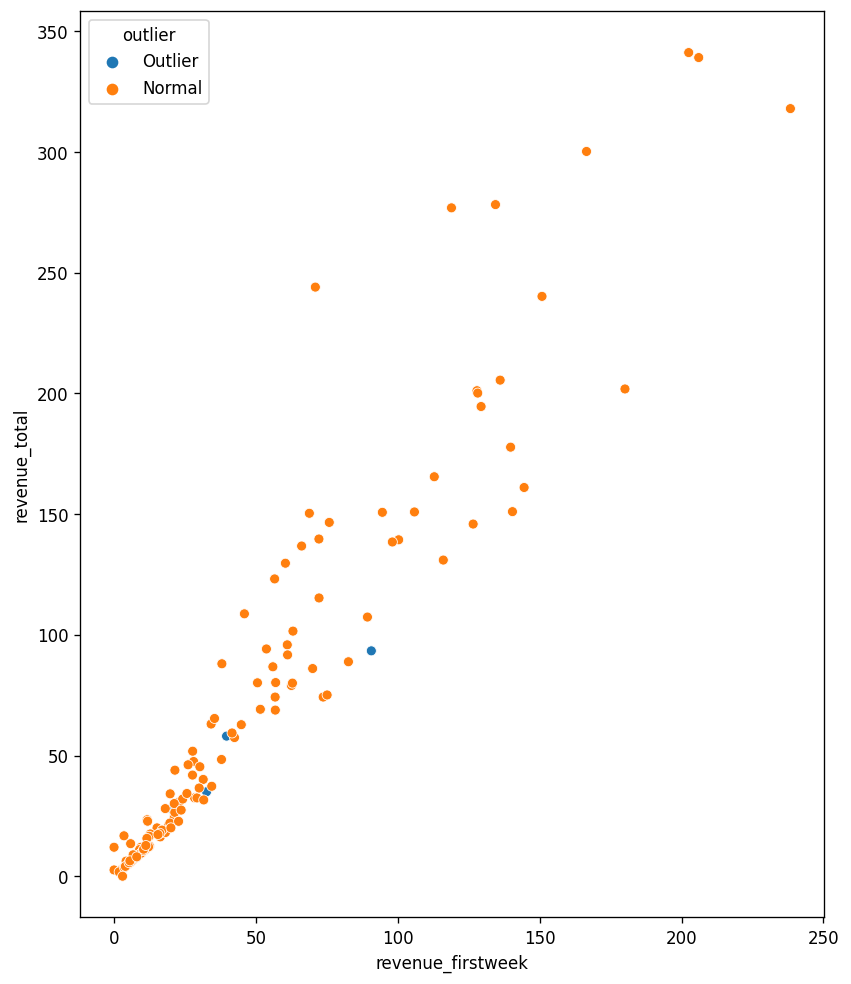

In [18]:
fig, ax1 = plt.subplots(1,1, figsize=(8,10), sharey=True, dpi=120)
sns.scatterplot(x="revenue_firstweek", y="revenue_total", hue="outlier", data=df_plot, ax=ax1)

In [19]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.linear_model import LinearRegression

# Using step selection from 
lr = LinearRegression()
X = df_dummy[var_list]
y = df['revenue_total']
sfs_forward = sfs(lr,
            k_features=(1, X.shape[1]),
            forward=True,
            floating=False,
            scoring='neg_mean_squared_error',
            cv=10)

sfs = sfs_forward.fit(X, y)
print('Best subset:', sfs.k_feature_names_)

Best subset: ('revenue_firstweek', 'gp_Comedy', 'gp_Jan')


# Answers

    1) Identify the variables that can be used to fit a linear regression model. 
        Based on correlation with revenue_firstweek, we should remove revenue_opening_day(93% correlation), revenue_opening_weekend(97% correlation)
        movie_name and Year, since these will not make sense in model
        movie_director : too many levels when compared to data set rows
        Because of high VIF, we have to remove run_time
        Taking everything into account, and after removing variables, based on high p-value, we finish with 'revenue_firstweek', 'gp_Comedy', 'gp_Historical', 'gp_Jan' 
    2) How is the total revenue impacted by genre of the movie? 
    For comedy movie,we see an increase in total revenue by 10 units, keeping evrything else same
    For historical movies, we see an increase in total revenue by 34.8470 units, keeping everything else same
    3) Does the release month have any role to play in movie's success? 
    For January month, we see increase in revenue by 34.8470
    4) Use any variable reduction technique to fit a model using all relevant variables. 
    Using SequentialFeatureSelector from mlxtend.feature_selection, with formward selection, we finish with 'revenue_firstweek', 'gp_Comedy', 'gp_Jan'
    5) Do you find any outliers in the dataset? What could be the possible reason for those being outliers? 
    From the analysis of outliers using dffits methods, we see that outliers near the mean regression line. This seems odd.